In [3]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,precision_score,recall_score,f1_score
from sklearn.svm import SVC 
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedShuffleSplit
import joblib

In [5]:
def count_design_patterns(csv_file):
    # Load the CSV file into a DataFrame
    df = pd.read_csv(csv_file)

    # Count the occurrences of each design pattern, including None/empty values
    pattern_counts = df['DesignPattern'].value_counts(dropna=False).reset_index()
    pattern_counts.columns = ['DesignPattern', 'Count']

    # Calculate the total count of design pattern entries (including None)
    total_count = pattern_counts['Count'].sum()

    # Print the counts for each design pattern
    print("Occurrences of each design pattern (including None):")
    print(pattern_counts.to_string(index=False))

    # Print the total count of all design pattern entries
    print(f"\nTotal count of all design pattern entries: {total_count}")

    # Check if there are None or empty entries and print their count if any
    if pattern_counts['DesignPattern'].isnull().any():
        none_count = pattern_counts[pattern_counts['DesignPattern'].isnull()]['Count'].iloc[0]
        print(f"\nNumber of rows with None or empty design pattern entries: {none_count}")

# Replace 'your_csv_file_path.csv' with the path to your CSV file
csv_file_path = './DPD_Att.csv'
count_design_patterns(csv_file_path)

Occurrences of each design pattern (including None):
  DesignPattern  Count
      Prototype    127
       Observer    127
       Strategy    127
        Memento    107
        Adapter    106
      Decorator    105
      Singleton    101
        Builder    101
  FactoryMethod    100
         Facade     99
        Visitor     98
AbstractFactory     97
          Proxy     96
            NaN     88
        Unknown     75

Total count of all design pattern entries: 1554

Number of rows with None or empty design pattern entries: 88


In [ ]:
data=pd.read_csv("DPD_Att_Classifier_256.csv")
data.head()

,Directory,File,DesignPattern,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,...,Feature_246,Feature_247,Feature_248,Feature_249,Feature_250,Feature_251,Feature_252,Feature_253,Feature_254,Feature_255
0,111,AbstractFactory,AbstractFactory,0.009923,0.019961,-0.013562,-0.003069,-0.013230,0.048970,0.021512,...,-0.051777,0.097458,-0.009427,0.027184,-0.011889,-0.074672,0.146362,0.034088,0.118662,-0.033793
1,111,DPAbstractFactory,Unknown,0.025731,-0.041754,-0.094777,0.015000,-0.090856,-0.008057,-0.041296,...,-0.112172,0.047929,-0.042468,-0.011076,-0.084124,-0.026756,0.148384,0.083692,0.105897,-0.024621
2,111,FactoryNotebookGamer,AbstractFactory,0.011921,0.001784,-0.058958,0.012461,-0.050621,0.017335,0.022669,...,-0.050007,0.069064,-0.048668,0.040862,0.088394,-0.042939,0.092905,0.074900,0.085188,-0.103398
3,111,FactoryNotebookOfficeW,Unknown,0.028296,-0.004623,-0.085723,0.020339,-0.030802,0.018229,-0.014785,...,-0.018946,0.079698,-0.030226,0.004979,0.082090,-0.078173,0.135302,0.115543,0.121336,-0.057344
4,111,FactoryProvider,AbstractFactory,0.012418,0.035557,-0.071139,-0.038619,-0.062490,-0.015598,0.011185,...,-0.066771,0.020901,-0.000590,-0.002110,0.001909,0.011913,0.184227,0.125253,0.077690,-0.030622


In [7]:
data["DesignPattern"].unique()

array(['AbstractFactory', 'Unknown', nan, 'Facade', 'Adapter', 'Memento',
       'Singleton', 'Proxy', 'Prototype', 'Observer', 'Decorator',
       'FactoryMethod', 'Builder', 'Visitor', 'Strategy'], dtype=object)

In [8]:
data["DesignPattern"].value_counts()

DesignPattern
Prototype          127
Observer           127
Strategy           127
Memento            107
Adapter            106
Decorator          105
Singleton          101
Builder            101
FactoryMethod      100
Facade              99
Visitor             98
AbstractFactory     97
Proxy               96
Unknown             75
Name: count, dtype: int64

In [ ]:
data['DesignPattern'].fillna('Unknown', inplace=True)
data["DesignPattern"].value_counts()

In [10]:
unknown_class = data[data['DesignPattern'] == 'Unknown']
sampled_unknown = unknown_class.sample(n=130, random_state=42)
other_classes = data[data['DesignPattern'] != 'Unknown']
data = pd.concat([sampled_unknown, other_classes])
data["DesignPattern"].value_counts()

DesignPattern
Unknown            130
Prototype          127
Observer           127
Strategy           127
Memento            107
Adapter            106
Decorator          105
Singleton          101
Builder            101
FactoryMethod      100
Facade              99
Visitor             98
AbstractFactory     97
Proxy               96
Name: count, dtype: int64

In [11]:
label_encoder = LabelEncoder()
data['pattern_encoded'] = label_encoder.fit_transform(data['DesignPattern'])


In [12]:
label_encoder.classes_

array(['AbstractFactory', 'Adapter', 'Builder', 'Decorator', 'Facade',
       'FactoryMethod', 'Memento', 'Observer', 'Prototype', 'Proxy',
       'Singleton', 'Strategy', 'Unknown', 'Visitor'], dtype=object)

In [13]:
np.save('label_classes.npy', label_encoder.classes_)

In [16]:
y = data['pattern_encoded']
X = data.drop(['DesignPattern', 'pattern_encoded','Directory','File'], axis=1)  # Features

In [17]:
from sklearn.model_selection import train_test_split
# Initialize StratifiedShuffleSplit with a 30% test size
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

# Perform the stratified split
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [18]:
joblib.dump(X_train.columns, "feature_names.pkl")


['feature_names.pkl']

In [12]:
# Import necessary libraries
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import joblib

# Initialize different classifiers
classifiers = {
    'Support Vector Machine': SVC(),
    'Logistic Regression': LogisticRegression(),
    'Multi-layer Perceptron': MLPClassifier(max_iter=1000),
}

# Initialize dictionaries to store evaluation metrics
accuracy_scores = {}
precision_scores = {}
recall_scores = {}
f1_scores = {}

# Train, evaluate, and save each classifier
for name, classifier in classifiers.items():
    # Train the classifier
    classifier.fit(X_train, y_train)
    
    # Save the classifier to a file
    filename = f'{name.lower().replace(" ", "_")}_classifier.pkl'
    joblib.dump(classifier, filename)
    print(f'{name} model saved as {filename}')
    
    # Evaluate the classifier
    y_pred = classifier.predict(X_test)
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    
    # Store metrics
    accuracy_scores[name] = accuracy
    precision_scores[name] = precision
    recall_scores[name] = recall
    f1_scores[name] = f1
    
    # Print metrics
    print(f'{name} Metrics:')
    print(f'Accuracy: {accuracy:.2f}')
    print(f'Precision (Macro): {precision:.2f}')
    print(f'Recall (Macro): {recall:.2f}')
    print(f'F1-Score (Macro): {f1:.2f}')
    print('-' * 30)


Support Vector Machine model saved as support_vector_machine_classifier.pkl
Support Vector Machine Metrics:
Accuracy: 0.87
Precision (Macro): 0.87
Recall (Macro): 0.87
F1-Score (Macro): 0.87
------------------------------
Logistic Regression model saved as logistic_regression_classifier.pkl
Logistic Regression Metrics:
Accuracy: 0.81
Precision (Macro): 0.82
Recall (Macro): 0.82
F1-Score (Macro): 0.81
------------------------------
Multi-layer Perceptron model saved as multi-layer_perceptron_classifier.pkl
Multi-layer Perceptron Metrics:
Accuracy: 0.86
Precision (Macro): 0.87
Recall (Macro): 0.86
F1-Score (Macro): 0.86
------------------------------


In [13]:
# Train and evaluate each classifier
for name, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    
    # Print the classification report
    report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
    print(f'{name} Classification Report:\n{report}')
    print('-' * 30)


Support Vector Machine Classification Report:
                 precision    recall  f1-score   support

AbstractFactory       0.86      0.86      0.86        29
        Adapter       0.91      0.94      0.92        32
        Builder       0.79      0.87      0.83        30
      Decorator       0.96      0.84      0.90        32
         Facade       0.90      0.90      0.90        30
  FactoryMethod       0.88      0.73      0.80        30
        Memento       0.94      0.91      0.92        32
       Observer       0.95      0.95      0.95        38
      Prototype       0.87      0.87      0.87        38
          Proxy       0.85      1.00      0.92        29
      Singleton       0.87      0.87      0.87        30
       Strategy       0.75      0.95      0.84        38
        Unknown       0.75      0.62      0.68        39
        Visitor       0.96      0.90      0.93        30

       accuracy                           0.87       457
      macro avg       0.87      0.87    

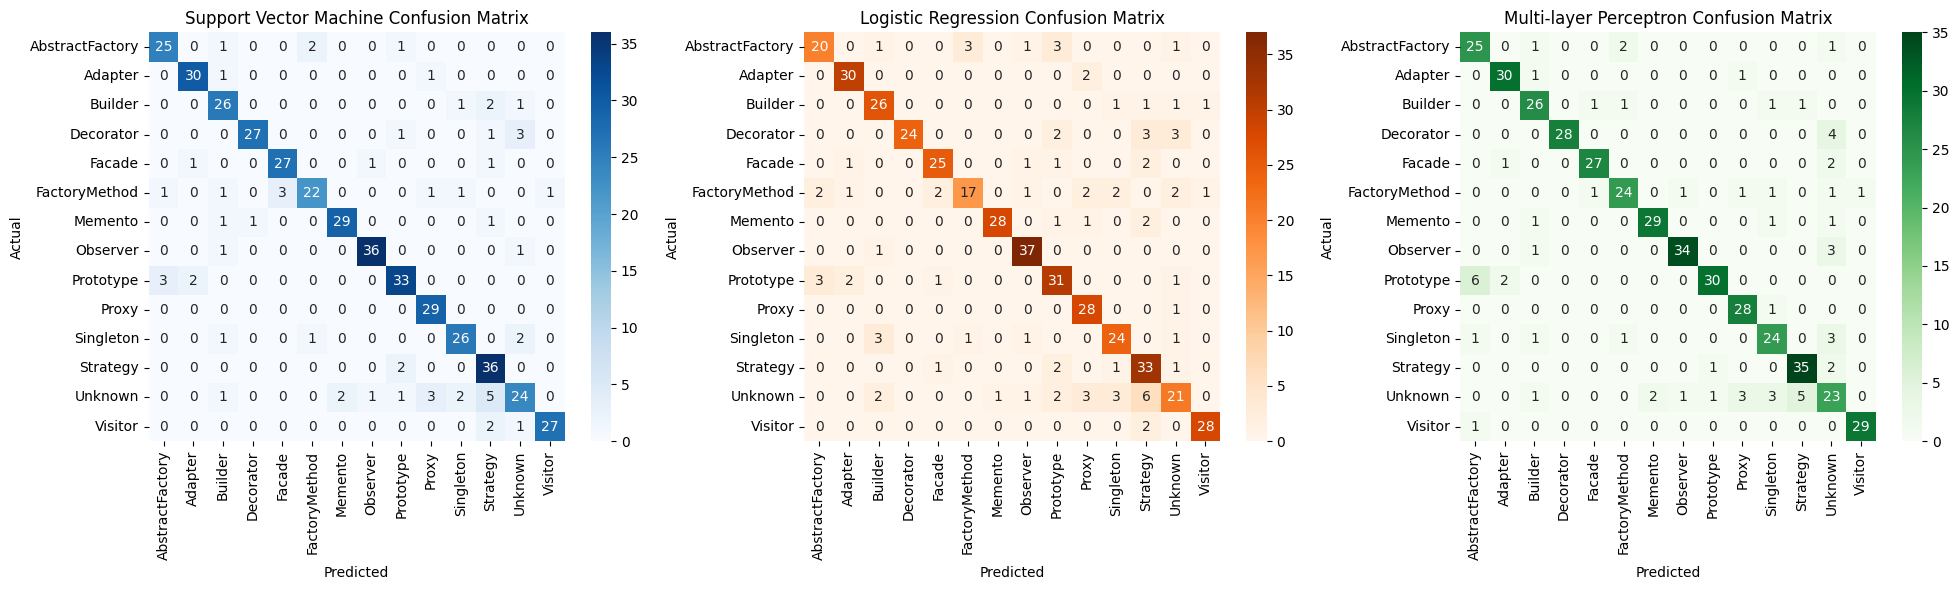

In [ ]:
colormaps = ['Blues', 'Oranges', 'Greens']
fig, axes = plt.subplots(1, 3, figsize=(20, 6))


for i, (name, classifier) in enumerate(classifiers.items()):
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    y_test_str = [label_encoder.classes_[i] for i in y_test]
    y_pred_str = [label_encoder.classes_[i] for i in y_pred]
    cm = confusion_matrix(y_test_str, y_pred_str, labels=label_encoder.classes_)
    ax = axes[i]
    sns.heatmap(cm, annot=True, fmt='d', cmap=colormaps[i], xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, ax=ax)
    ax.set_title(f'{name} Confusion Matrix')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()


# Inference 

In [22]:

# Load classifiers from files
svm_classifier = joblib.load('support_vector_machine_classifier.pkl')
logistic_regression_classifier = joblib.load('logistic_regression_classifier.pkl')
mlp_classifier = joblib.load('multi-layer_perceptron_classifier.pkl')


In [19]:
from embeddings import encode_java_code
# encode your testing code and transform the embedding tensor to a 2D array


# this is an example of a Factory Method Java code
test= encode_java_code("""public interface CoffeeShopFactory {
    CoffeeOrder createCoffeeOrder();
}
public class StarbucksFactory implements CoffeeShopFactory {
    @Override
    public CoffeeOrder createCoffeeOrder() {
        return new StarbucksCoffeeOrder();
    }
}
public class DunkinDonutsFactory implements CoffeeShopFactory {
    @Override
    public CoffeeOrder createCoffeeOrder() {
        return new DunkinDonutsCoffeeOrder();
    }
}
public interface CoffeeOrder {
    void prepareCoffee();
}
public class StarbucksCoffeeOrder implements CoffeeOrder {
    @Override
    public void prepareCoffee() {
        System.out.println("Preparing coffee at Starbucks.");
    }
}
public class DunkinDonutsCoffeeOrder implements CoffeeOrder {
    @Override
    public void prepareCoffee() {
        System.out.println("Preparing coffee at Dunkin' Donuts.");
    }
}


""").tolist()
# test is a vector of embeddings , we reshape it to a vector of vectors. Row is a vector of vectors [[]]
row = np.array(test).reshape(1, -1)
#print("The embedding vector of this java class is \n",row)

# Add feature names for compatibility with the trained model
feature_names = X_train.columns  # Replace this with the actual feature names
row_df = pd.DataFrame(row, columns=feature_names)
print("The embedding vector of this Java class as a DataFrame is:")
print(row_df)



The embedding vector of this Java class as a DataFrame is:
   Feature_0  Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  \
0   0.043639  -0.038864  -0.122658  -0.020749  -0.085473  -0.025063   

   Feature_6  Feature_7  Feature_8  Feature_9  ...  Feature_246  Feature_247  \
0    0.01872    -0.0773  -0.012007  -0.020648  ...    -0.035025     0.041006   

   Feature_248  Feature_249  Feature_250  Feature_251  Feature_252  \
0    -0.046186     0.084225     0.011568    -0.023271     0.092078   

   Feature_253  Feature_254  Feature_255  
0     0.008685     0.060024     0.011479  

[1 rows x 256 columns]


In [50]:
test= encode_java_code("""
class A{
    private static A single_instance = null;

    public String s;
 
    private A()
    {
        s = "ABCJKLWOPKJBV";
    }
 
    public static synchronized A getInstance()
    {
        if (single_instance == null)
            single_instance = new A();
 
        return single_instance;
    }
}

""").tolist()
# test is a vector of embeddings , we reshape it to a vector of vectors. Row is a vector of vectors [[]]
row = np.array(test).reshape(1, -1)
#print("The embedding vector of this java class is \n",row)

# Add feature names for compatibility with the trained model
feature_names = X_train.columns  # Replace this with the actual feature names
row_df = pd.DataFrame(row, columns=feature_names)
print("The embedding vector of this Java class as a DataFrame is:")
print(row_df)


The embedding vector of this Java class as a DataFrame is:
   Feature_0  Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  \
0   -0.04022   0.049868  -0.147489  -0.035903  -0.079045  -0.013446   

   Feature_6  Feature_7  Feature_8  Feature_9  ...  Feature_246  Feature_247  \
0  -0.001947  -0.117248  -0.098706  -0.036602  ...    -0.037736      0.07062   

   Feature_248  Feature_249  Feature_250  Feature_251  Feature_252  \
0    -0.032714     0.043393    -0.028434    -0.126432     0.007079   

   Feature_253  Feature_254  Feature_255  
0    -0.002644     0.099883     0.072202  

[1 rows x 256 columns]


In [51]:
# Dictionary to store predictions
predictions = {}

# Predict and print results for each classifier
for name, classifier in classifiers.items():
    prediction = classifier.predict(row_df)
    
    # Decode the numeric label into the design pattern name
    decoded_prediction = label_encoder.inverse_transform([prediction[0]])[0]
    predictions[name] = decoded_prediction
    
    print(f'{name} Prediction: {decoded_prediction}')

Support Vector Machine Prediction: Singleton
Logistic Regression Prediction: Singleton
Multi-layer Perceptron Prediction: Singleton


In [54]:
test= encode_java_code("""
public class A implements B{
  private double totalPostageForCart;

  public void F(Book book) {
 
    if(book.getPrice() < 10.0) {
      totalPostageForCart += book.getWeight() * 2;
    }
  }
                       
  public void F(CD cd) {...}
  public void F(DVD dvd) {...}

  public double getTotalPostage() {
    return totalPostageForCart;
  }
}

""").tolist()
# test is a vector of embeddings , we reshape it to a vector of vectors. Row is a vector of vectors [[]]
row = np.array(test).reshape(1, -1)
#print("The embedding vector of this java class is \n",row)

# Add feature names for compatibility with the trained model
feature_names = X_train.columns  # Replace this with the actual feature names
row_df = pd.DataFrame(row, columns=feature_names)
print("The embedding vector of this Java class as a DataFrame is:")
print(row_df)

The embedding vector of this Java class as a DataFrame is:
   Feature_0  Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  \
0   0.009313   0.000377  -0.089646   0.001916  -0.102312   -0.04391   

   Feature_6  Feature_7  Feature_8  Feature_9  ...  Feature_246  Feature_247  \
0  -0.017193  -0.113086   0.028686  -0.006799  ...    -0.072802     0.103369   

   Feature_248  Feature_249  Feature_250  Feature_251  Feature_252  \
0    -0.001147     0.052713    -0.028026    -0.063462     0.150454   

   Feature_253  Feature_254  Feature_255  
0     0.021778     0.065046     0.075132  

[1 rows x 256 columns]


In [55]:
# Dictionary to store predictions
predictions = {}

# Predict and print results for each classifier
for name, classifier in classifiers.items():
    prediction = classifier.predict(row_df)
    
    # Decode the numeric label into the design pattern name
    decoded_prediction = label_encoder.inverse_transform([prediction[0]])[0]
    predictions[name] = decoded_prediction
    
    print(f'{name} Prediction: {decoded_prediction}')

Support Vector Machine Prediction: Strategy
Logistic Regression Prediction: Strategy
Multi-layer Perceptron Prediction: Strategy


In [64]:
test= encode_java_code("""

package a;

import java.util.Map;

public class b extends a {
   private final b.a a = b.b.b.a(new Object[]{this.getClass().getName()});
   private static final String b;
   private static final String[] c;

   public b() {
   }

   public Map a(Object[] var1) {
      Map var2 = (Map)var1[0];
      String[] var6 = c;
      this.a.a(new Object[]{var6[1]});
      String var3 = (String)var2.get(var6[4]);
      String var4 = (String)var2.get(var6[0]);
      var2.put(var6[3], var4 + var3);
      String var5 = (String)var2.get(var6[6]);
      var2.put(var6[5], var5);
      var2.putAll(super.b(new Object[0]));
      return var2;
   }
}


""").tolist()
# test is a vector of embeddings , we reshape it to a vector of vectors. Row is a vector of vectors [[]]
row = np.array(test).reshape(1, -1)
#print("The embedding vector of this java class is \n",row)

# Add feature names for compatibility with the trained model
feature_names = X_train.columns  # Replace this with the actual feature names
row_df = pd.DataFrame(row, columns=feature_names)
print("The embedding vector of this Java class as a DataFrame is:")
print(row_df)

The embedding vector of this Java class as a DataFrame is:
   Feature_0  Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  \
0  -0.138774   0.034143  -0.136572  -0.006927  -0.127609   0.010248   

   Feature_6  Feature_7  Feature_8  Feature_9  ...  Feature_246  Feature_247  \
0   0.016604  -0.078234   0.004217    0.02188  ...     0.006778     0.030651   

   Feature_248  Feature_249  Feature_250  Feature_251  Feature_252  \
0    -0.111314     0.034065    -0.021944    -0.029273     0.071949   

   Feature_253  Feature_254  Feature_255  
0     0.073852     0.052798     0.081655  

[1 rows x 256 columns]


In [65]:
# Dictionary to store predictions
predictions = {}

# Predict and print results for each classifier
for name, classifier in classifiers.items():
    prediction = classifier.predict(row_df)
    
    # Decode the numeric label into the design pattern name
    decoded_prediction = label_encoder.inverse_transform([prediction[0]])[0]
    predictions[name] = decoded_prediction
    
    print(f'{name} Prediction: {decoded_prediction}')

Support Vector Machine Prediction: Prototype
Logistic Regression Prediction: Prototype
Multi-layer Perceptron Prediction: Prototype


In [28]:
test= encode_java_code("""

import cucumber.api.java.ObjectFactory;
class SingletonFactory implements ObjectFactory {
    private Object singleton;
    public SingletonFactory() {
        this(null);
    }
    public SingletonFactory(Object singleton) {
        this.singleton = singleton;
    }
    @Override
    public void start() {
    }
    @Override
    public void stop() {
    }
    @Override
    public boolean addClass(Class<?> clazz) {
        return true;
    }
    @Override
    public <T> T getInstance(Class<T> type) {
        if (singleton == null) {
            throw new IllegalStateException("No object is set");
        }
        return type.cast(singleton);
    }
    public void setInstance(Object o) {
        singleton = o;
    }
}

""").tolist()
# test is a vector of embeddings , we reshape it to a vector of vectors. Row is a vector of vectors [[]]
row = np.array(test).reshape(1, -1)
#print("The embedding vector of this java class is \n",row)

# Add feature names for compatibility with the trained model
feature_names = X_train.columns  # Replace this with the actual feature names
row_df = pd.DataFrame(row, columns=feature_names)
print("The embedding vector of this Java class as a DataFrame is:")
print(row_df)

The embedding vector of this Java class as a DataFrame is:
   Feature_0  Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  \
0  -0.053019   0.074818  -0.109593  -0.027645  -0.073172  -0.009991   

   Feature_6  Feature_7  Feature_8  Feature_9  ...  Feature_246  Feature_247  \
0  -0.002805  -0.010236  -0.057974   0.042738  ...    -0.023417     0.077954   

   Feature_248  Feature_249  Feature_250  Feature_251  Feature_252  \
0    -0.048381     0.010232    -0.065642     0.024236      0.09337   

   Feature_253  Feature_254  Feature_255  
0     0.017413     0.129484    -0.020465  

[1 rows x 256 columns]


In [29]:
# Dictionary to store predictions
predictions = {}

# Predict and print results for each classifier
for name, classifier in classifiers.items():
    prediction = classifier.predict(row_df)
    
    # Decode the numeric label into the design pattern name
    decoded_prediction = label_encoder.inverse_transform([prediction[0]])[0]
    predictions[name] = decoded_prediction
    
    print(f'{name} Prediction: {decoded_prediction}')

Support Vector Machine Prediction: Singleton
Logistic Regression Prediction: Singleton
Multi-layer Perceptron Prediction: Singleton


## Inference (sample tests: ProGuard)

In [ ]:
## obfu 14 decorator
test= encode_java_code("""

import com.ipeirotis.gal.core.Worker;
import com.ipeirotis.gal.core.Worker.ClassificationMethod;
import com.ipeirotis.gal.decorator.FieldAccessors.EntityFieldAccessor;
public class WorkerDecorator extends Decorator<Worker> {
	private Worker worker;
	public WorkerDecorator(Worker wrapped) {
		super(wrapped);
		this.worker = (Worker) wrapped;
	}
	public Double getExpectedCost() {
		return worker.getWorkerQuality(worker.getDs().getCategories(), ClassificationMethod.DS_Soft_Estm);
	}
	public Double getMinCost() {
		return worker.getWorkerQuality(worker.getDs().getCategories(), ClassificationMethod.DS_MinCost_Estm);
	}
	public Double getMaxLikelihoodCost() {
		return worker.getWorkerQuality(worker.getDs().getCategories(), ClassificationMethod.DS_MaxLikelihood_Estm);
	}
	public Double getExpCostEval() {
		return worker.getWorkerQuality(worker.getDs().getCategories(), ClassificationMethod.DS_Soft_Eval);
	}
	public Double getMinCostEval() {
		return worker.getWorkerQuality(worker.getDs().getCategories(), ClassificationMethod.DS_MinCost_Eval);
	}
	public Double getMaxLikelihoodCostEval() {
		return worker.getWorkerQuality(worker.getDs().getCategories(), ClassificationMethod.DS_MaxLikelihood_Eval);
	}
	public Double getWeightedMaxLikelihoodCost() {
		return worker.getWorkerQuality(worker.getDs().getCategories(), ClassificationMethod.DS_MaxLikelihood_Estm);
	}
	public Double getWeightedMaxLikelihoodCostEval() {
		return worker.getWorkerQuality(worker.getDs().getCategories(), ClassificationMethod.DS_MaxLikelihood_Eval);
	}
	public Double getWeightedQualityForEstQualityExp() {
		return getWeightedQualityFor(FieldAccessors.WORKER_ACCESSORS.EST_QUALITY_EXP);
	}
	public Double getWeightedQualityForEstQualityOpt() {
		return getWeightedQualityFor(FieldAccessors.WORKER_ACCESSORS.EST_QUALITY_OPT);
	}
	public Double getWeightedQualityForEvalQualityExp() {
		return getWeightedQualityFor(FieldAccessors.WORKER_ACCESSORS.EVAL_QUALITY_EXP);
	}
	public Double getWeightedQualityForEvalQualityOpt() {
		return getWeightedQualityFor(FieldAccessors.WORKER_ACCESSORS.EVAL_QUALITY_OPT);
	}
	private Double getWeightedQualityFor(EntityFieldAccessor fieldAccessor) {
		Double metricValue = getMetric(object, fieldAccessor);
		if (metricValue.isNaN())
			return null;
		return metricValue;
	}
	private Double getMetric(Worker w, EntityFieldAccessor fieldAccessor) {
		Object objVal = fieldAccessor.getValue(w);
		return (null == objVal ? null : ((Double) objVal));
	}
	public Double getNumContributions() {
		return 0d + worker.getAssignedLabels().size();
	}
	public Double getNumGoldTests() {
		return 0d + worker.getDs().countGoldTests(worker.getAssignedLabels());
	}
}

""").tolist()
# test is a vector of embeddings , we reshape it to a vector of vectors. Row is a vector of vectors [[]]
row = np.array(test).reshape(1, -1)
#print("The embedding vector of this java class is \n",row)

# Add feature names for compatibility with the trained model
feature_names = X_train.columns  # Replace this with the actual feature names
row_df = pd.DataFrame(row, columns=feature_names)
#print("The embedding vector of this Java class as a DataFrame is:")
#print(row_df)

# Dictionary to store predictions
predictions = {}

# Predict and print results for each classifier
for name, classifier in classifiers.items():
    prediction = classifier.predict(row_df)
    
    # Decode the numeric label into the design pattern name
    decoded_prediction = label_encoder.inverse_transform([prediction[0]])[0]
    predictions[name] = decoded_prediction
    
    print(f'{name} Prediction: {decoded_prediction}')

Support Vector Machine Prediction: Decorator
Logistic Regression Prediction: Decorator
Multi-layer Perceptron Prediction: Decorator


In [40]:
## 
test= encode_java_code("""

import a.a.a.a.c;

public class b extends a {
   private a.a.a.a.b a;

   public b(a.a.a.a.b var1) {
      super(var1);
      this.a = var1;
   }

   public Double a() {
      return this.a.a(this.a.a().a(), c.a);
   }

   public Double b() {
      return this.a.a(this.a.a().a(), c.b);
   }

   public Double c() {
      return this.a.a(this.a.a().a(), c.c);
   }

   public Double d() {
      return this.a.a(this.a.a().a(), c.d);
   }

   public Double e() {
      return this.a.a(this.a.a().a(), c.e);
   }

   public Double f() {
      return this.a.a(this.a.a().a(), c.f);
   }

   public Double g() {
      return this.a.a(this.a.a().a(), c.c);
   }

   public Double h() {
      return this.a.a(this.a.a().a(), c.f);
   }

   public Double i() {
      return this.a(a.a.a.b.c.a);
   }

   public Double j() {
      return this.a(a.a.a.b.c.b);
   }

   public Double k() {
      return this.a(a.a.a.b.c.c);
   }

   public Double l() {
      return this.a(a.a.a.b.c.d);
   }

   private Double a(a.a.a.b.b var1) {
      Double var2 = this.a(this.a, var1);
      return var2.isNaN() ? null : var2;
   }

   private Double a(a.a.a.a.b var1, a.a.a.b.b var2) {
      Object var3 = var2.a(var1);
      return var3 == null ? null : (Double)var3;
   }

   public Double m() {
      return 0.0 + this.a.b().a();
   }

   public Double n() {
      return 0.0 + this.a.a().a(this.a.b());
   }
}

""").tolist()
# test is a vector of embeddings , we reshape it to a vector of vectors. Row is a vector of vectors [[]]
row = np.array(test).reshape(1, -1)
#print("The embedding vector of this java class is \n",row)

# Add feature names for compatibility with the trained model
feature_names = X_train.columns  # Replace this with the actual feature names
row_df = pd.DataFrame(row, columns=feature_names)
#print("The embedding vector of this Java class as a DataFrame is:")
#print(row_df)

# Dictionary to store predictions
predictions = {}

# Predict and print results for each classifier
for name, classifier in classifiers.items():
    prediction = classifier.predict(row_df)
    
    # Decode the numeric label into the design pattern name
    decoded_prediction = label_encoder.inverse_transform([prediction[0]])[0]
    predictions[name] = decoded_prediction
    
    print(f'{name} Prediction: {decoded_prediction}')

Support Vector Machine Prediction: Prototype
Logistic Regression Prediction: Prototype
Multi-layer Perceptron Prediction: Prototype


In [ ]:
## obfu25
test= encode_java_code("""
import java.util.Set;
public interface GridPrototype extends GridData
{
    GridPrototype getParentProto();
    void setParentProto( GridPrototype proto );
    boolean hasSlot( GridToken name );
    GridPrototype getSlot( GridToken name );
    GridPrototype defineSlot( GridToken name );
    GridPrototype defineAndAssignSlot( GridToken name, GridPrototype value );
    GridPrototype setSlot( GridToken name, GridPrototype value );
    Set<GridToken> getSlotNames();
    String getTypeName();
}


""").tolist()
# test is a vector of embeddings , we reshape it to a vector of vectors. Row is a vector of vectors [[]]
row = np.array(test).reshape(1, -1)
#print("The embedding vector of this java class is \n",row)

# Add feature names for compatibility with the trained model
feature_names = X_train.columns  # Replace this with the actual feature names
row_df = pd.DataFrame(row, columns=feature_names)
#print("The embedding vector of this Java class as a DataFrame is:")
#print(row_df)

# Dictionary to store predictions
predictions = {}

# Predict and print results for each classifier
for name, classifier in classifiers.items():
    prediction = classifier.predict(row_df)
    
    # Decode the numeric label into the design pattern name
    decoded_prediction = label_encoder.inverse_transform([prediction[0]])[0]
    predictions[name] = decoded_prediction
    
    print(f'{name} Prediction: {decoded_prediction}')

Support Vector Machine Prediction: Prototype
Logistic Regression Prediction: Prototype
Multi-layer Perceptron Prediction: Prototype


In [ ]:
## 
test= encode_java_code("""
package a.a;

import java.util.Set;

public interface b extends a {
   b a();

   void a(b var1);

   boolean a(c var1);

   b a(c var1);

   b b(c var1);

   b a(c var1, b var2);

   b b(c var1, b var2);

   Set a();

   String a();
}

""").tolist()
# test is a vector of embeddings , we reshape it to a vector of vectors. Row is a vector of vectors [[]]
row = np.array(test).reshape(1, -1)
#print("The embedding vector of this java class is \n",row)

# Add feature names for compatibility with the trained model
feature_names = X_train.columns  # Replace this with the actual feature names
row_df = pd.DataFrame(row, columns=feature_names)
#print("The embedding vector of this Java class as a DataFrame is:")
#print(row_df)

# Dictionary to store predictions
predictions = {}

# Predict and print results for each classifier
for name, classifier in classifiers.items():
    prediction = classifier.predict(row_df)
    
    # Decode the numeric label into the design pattern name
    decoded_prediction = label_encoder.inverse_transform([prediction[0]])[0]
    predictions[name] = decoded_prediction
    
    print(f'{name} Prediction: {decoded_prediction}')

Support Vector Machine Prediction: Prototype
Logistic Regression Prediction: Prototype
Multi-layer Perceptron Prediction: Visitor
